# [**Caractéristique de Fonctionnement du Récepteur (Receiver Operating Characteristic - ROC) avec validation croisée**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/3_model_selection/plot_roc_crossval.ipynb)<br/>([*Receiver Operating Characteristic (ROC) with cross validation*](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html))

Cet exemple présente comment estimer et visualiser la variance de la métrique ROC (Receiver Operating Characteristic) en utilisant la validation croisée.

Les courbes ROC représentent généralement le taux de vrais positifs (True Positive Rate - TPR) sur l'axe Y et le taux de faux positifs (False Positive Rate - FPR) sur l'axe X. Cela signifie que le coin supérieur gauche du graphique est le point "idéal" - un FPR de zéro et un TPR de un. Cela n'est pas très réaliste, mais cela signifie qu'une plus grande aire sous la courbe (Area Under the Curve - AUC) est généralement meilleure. La "pente" des courbes ROC est également importante, car il est idéal de maximiser le TPR tout en minimisant le FPR.

Cet exemple montre la réponse ROC de différents ensembles de données, créés à partir de la validation croisée K-fold. En prenant toutes ces courbes, il est possible de calculer la moyenne de l'AUC et de voir la variance de la courbe lorsque l'ensemble d'entraînement est divisé en différents sous-ensembles. Cela montre approximativement comment la sortie du classifieur est affectée par les changements dans les données d'entraînement et à quel point les divisions générées par la validation croisée K-fold diffèrent les unes des autres.

> **Note** : Voir l'exemple [**Courbe de Caractéristique de Fonctionnement du Récepteur (ROC) Multiclasse**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/3_model_selection/plot_roc.ipynb) pour obtenir des informations complémentaires sur les stratégies d'agrégation permettant de généraliser les métriques pour les classifieurs multiclasses.

# Chargement et préparation des données

Nous importons le [**Jeu de données des plantes Iris** (7.1.1)](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset), qui contient 3 classes, chacune correspondant à un type de plante Iris. Une classe est linéairement séparable des 2 autres ; ces dernières **ne sont pas** linéairement séparables entre elles.

Dans ce qui suit, nous binarisons l'ensemble de données en supprimant la classe "virginica" (`class_id=2`). Cela signifie que la classe "versicolor" (`class_id=1`) est considérée comme la classe positive et "setosa" comme la classe négative (`class_id=0`).

In [1]:
import numpy as np

from sklearn.datasets import load_iris

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

Nous ajoutons également des caractéristiques bruitées pour rendre le problème plus difficile.

In [2]:
random_state = np.random.RandomState(0)
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

## Classification et analyse de la ROC

Nous exécutons ici un classifieur [**`SVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) avec validation croisée et tracé des courbes ROC pour chaque pli. Notez que la base de référence pour définir le niveau de chance (courbe ROC en pointillés) correspond à un classifieur qui prédit toujours la classe la plus fréquente.

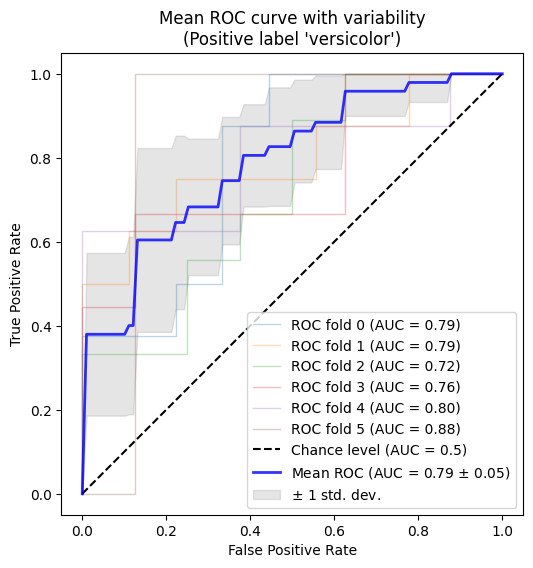

In [3]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()